# k-Means

El algoritmo k-means es un algoritmo de aprendizaje no supervisado que se enmarca dentro de la familia de los algoritmos de *clustering*. Su objetivo, por tanto, consiste en agrupar datos no etiquetados. Veamos como funciona mediante un ejemplo.

Cargamos la librería `sklearn`:

In [1]:
import sklearn

Y prepramos un conjunto de datos sintético. Puesto que el objetivo de k-means es encontrar clusters, vamos a generar dos clusters con dos distribuciones gausianas:

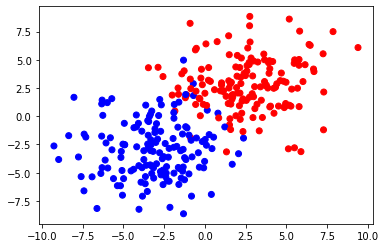

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, n_features=2, centers=[[-3,-3], [3,3]], cluster_std=2.5, random_state=23)

plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr)

No obstante, hay que tener en cuenta que el algoritmo, al ser no supervisado, no conocerá estas etiquetas por lo que trabajará únicamente con las coordenadas de los puntos para determinar los clusters. Las etiquetas (los colores rojo y azul) no se usarán. Deberá buscar los clusters "a ciegas", por lo que el conjunto de datos se verá visto del siguiente modo por el algoritmo:

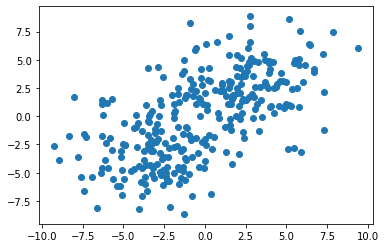

In [3]:
plt.figure()
plt.scatter(X[:,0], X[:,1])

El funcionamiento del algoritmo es muy sencillo:

1.   Se define el número de clústeres (*k*) que se quieren construir.
2.   Se inicializan *k* centroides con valores aleatorios dentro del rango de los datos. En algunas ocasiones, se eligen al azar *k* muestras del conjunto de datos para inicializar estos centroides.
3.   Se asigna cada muestra del conjunto de datos al centroide más cercano.
4.   Se actualizan los centroides con el valor promedio de todas las muestras que les han sido asignadas.
5.   Se repiten los pasos 3 y 4 hasta que el algoritmo converja.

Podemos ilustrar de forma gráfica este proceso haciendo uso de la implementación del algoritmo [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) de `skearn`. Las siguientes 4 imágenes muestran las 4 primeras iteraciones de una ejecución de k-means para 2 clusters ($k=2$). Como observamos se van desplazando los centroides hacia los centros de las nubes de puntos que generamos anteriormente.



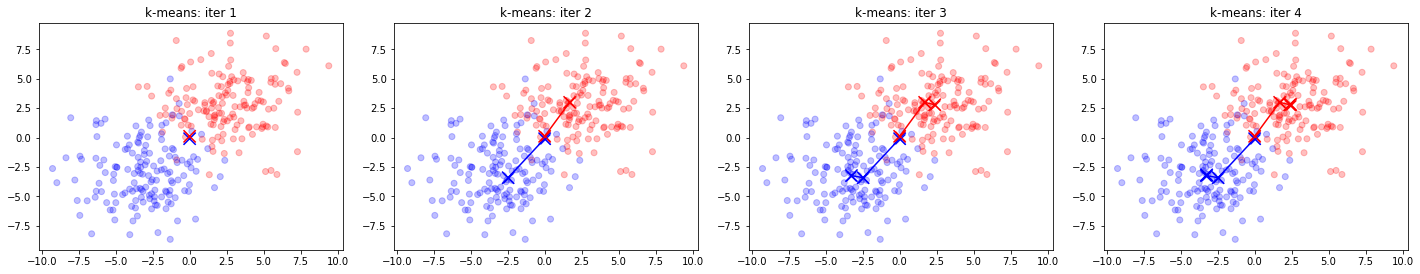

In [4]:
import numpy as np
from sklearn.cluster import KMeans

# initial centroids
centroids=np.array([[0,-0.1], [0,0.1]])

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
fig.tight_layout(pad=2.0)

axs[0].set_title('k-means: iter 1')

nearest = lambda p: 0 if np.linalg.norm(p-centroids[0])<np.linalg.norm(p-centroids[1]) else 1
labels = nearest(X)

labels = np.apply_along_axis(nearest, 1, X)

axs[0].scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr, alpha=0.25)
axs[0].scatter(centroids[:,0], centroids[:,1], color=['b','r'], marker="x", s=150)

for i, iters in enumerate([1,2,3]):
  kmeans = KMeans(n_clusters=2, init=centroids[:2], n_init=1, max_iter=iters, random_state=23)
  kmeans.fit(X)
  labels = kmeans.predict(X)

  centroids = np.concatenate((centroids, kmeans.cluster_centers_))

  axs[i+1].set_title('k-means: iter ' + str(iters+1))

  axs[i+1].scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr, alpha=0.25)
  axs[i+1].scatter(centroids[:,0], centroids[:,1], color=['b','r']*(i+2), marker="x", s=150)
  axs[i+1].plot(centroids[::2,0], centroids[::2,1], color='blue', marker="x", markersize=10)
  axs[i+1].plot(centroids[1::2,0], centroids[1::2,1], color='red', marker="x", markersize=10)


Una vez concluido el entranamiento, se definirán dos regiones en todo el espacio de los datos, una para cada clúster. La siguiente imagen muestra estas regiones. La mayoría de datos se habrán agrupado correctamente, aunque, los que estén cerca de la frontera del clúster, tendrán más probabilidad de no agruparse en el clúster adecuado.

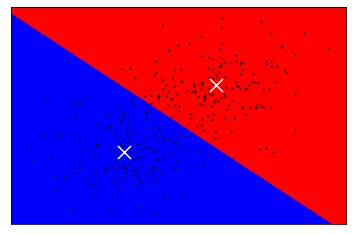

In [5]:
kmeans = KMeans(n_clusters=2, init=centroids[:2], n_init=1, max_iter=3, random_state=23)
kmeans.fit(X)

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = .02 # step size of the mesh. Decrease to increase the quality of the VQ.
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.bwr,
           aspect='auto', origin='lower')

plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Visto el funcionamiento del algoritmo podemos afirmar que la clave del mismo radica en la métrica utilizada para determinar la distancia entre dos muestras y, por tanto, asignar el centroide más cercano a cada muestra. Lo más habitual es emplear la distnacia euclidea:

$$
dist(x_i,x_j) = \sqrt{(x_{i,1}-x_{j,1})^2 + (x_{i,2}-x_{j,2})^2 + \dots + (x_{i,m}-x_{j,m})^2} = \sqrt{\sum_{f=1}^m (x_{i,f}-x_{j,f})^2}
$$

No obstante, pueden emplearse otras distancias en caso necesario.

## Caso práctico: k-Means sobre MNIST

Vamos a desarrollar un ejemplo que nos permita entender cómo funciona el algoritmo de clústering KMeans con ayuda de dataset de MNIST.

Cargamos el dataset de MNIST, que ha sido denominado `digits`:

In [6]:
from sklearn.datasets import load_digits
mnist = load_digits()

Este dataset contiene un total de 1797 imágenes de dígitos manuscritos en imágenes de una resolución de 8x8 píxeles. Los dígitos van desde el 0 hasta el 9, por lo que, en total, hay 10 clases diferentes. El dataset está balanceado puesto que hay, aproximadamente, 180 muestras por cada clase.

El dataset está preparado para que podamos visualizar la imágenes de los dígitos. En concreto, el campo `images` contiene una matriz cuadrada bidimensional de 8 filas y 8 columnas en las que cada valor se corresponde con la cantidad de color negro de un pixel.

Veamos como se ha codificado:

In [7]:
mnist.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

En lugar de una representación matricial de los número podemos obtener, con ayuda de MatPlotLib una representación gráfica de los mismos.

In [8]:
import matplotlib.pyplot as plt

In [9]:
import math
def paint_digits (images):
  for index, image in enumerate(images):
    plt.subplot(math.ceil(len(images)/5), 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

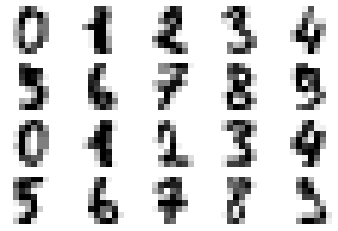

In [10]:
paint_digits(mnist.images[:20])

Evidentemente, esta representación matricial no es adecuada para ser utilizada por un algoritmo de *machine learning*. Necesitamos que cada imagen sea un vector unidimensional.

Como siempre, los datos del dataset se encuentra en el objeto `data`. Observa las diferencias entre ambas codificaciones.

In [11]:
mnist.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [ ]:
mnist.data[0]

Ahora que hemos codificado nuestras imágenes en vectores, vamos a proceder a ejecutar el algoritmo k-Means. Como sabemos, este algoritmo es de aprendizaje no supervisado, por lo que para esta actividad, ignoraremos completamente cualquier referencia a `mnist.target` que contiene las clases de cada uno de los digitos manuscritos.

El objetivo de este ejemplo es entender cómo funciona el algoritmo k-Means y, por lo tanto, vamos a prescindir de cualquier medida de calidad. Esto implica que **NO** debemos dividir el dataset en entrenamiento y test. Utilizaremos **TODOS** los datos que tenemos para entrenar nuestro modelo k-Means y luego analizaremos los resultados obtenidos.

Procedemos, por tanto, a ejecutar KMeans sobre los datos disponibles, es decir, sobre `mnist.data`:

In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 10, random_state=0)
kmeans.fit(mnist.data)

KMeans(n_clusters=10, random_state=0)

Tras su entrenamiento, k-Means genera un centroide por cada cluster definido. Este centroide podemos entenderlo como la muestra promedio de cada uno de los clusters encontrados. La forma del centroide será idéntica a la forma de los datos con los que se ha entrenado.

Podemos acceder a los centroides de k-Means mediante `kmeans.cluster_centers_`.

In [13]:
kmeans.cluster_centers_

array([[ 0.00000000e+00,  1.66533454e-16,  3.07228916e-01,
         7.16265060e+00,  1.19457831e+01,  1.93373494e+00,
         1.50602410e-01,  5.42168675e-02,  1.73472348e-18,
         1.20481928e-02,  3.28313253e+00,  1.37951807e+01,
         8.46385542e+00,  1.53012048e+00,  9.75903614e-01,
         2.77108434e-01,  8.67361738e-19,  6.44578313e-01,
         1.07108434e+01,  1.15602410e+01,  4.33734940e+00,
         5.25903614e+00,  3.87349398e+00,  3.25301205e-01,
         6.02409639e-03,  4.75903614e+00,  1.47590361e+01,
         5.86144578e+00,  6.87951807e+00,  1.07530120e+01,
         6.21686747e+00,  1.80722892e-02,  0.00000000e+00,
         8.92771084e+00,  1.48072289e+01,  9.35542169e+00,
         1.28132530e+01,  1.43915663e+01,  5.48192771e+00,
         0.00000000e+00,  9.63855422e-02,  6.50602410e+00,
         1.16867470e+01,  1.23433735e+01,  1.48373494e+01,
         1.07590361e+01,  1.56626506e+00,  1.04083409e-17,
         6.02409639e-02,  1.11445783e+00,  3.00000000e+0

Puesto que los centroides son idénticos (en estructura) a cualquiera de los datos con los que hemos entrenado k-Means... ¡Podemos pintarlos!

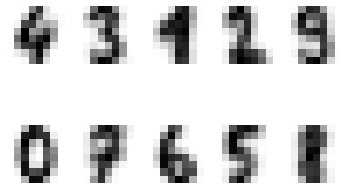

In [14]:
paint_digits(list(map(lambda centroid: centroid.reshape(8, 8), kmeans.cluster_centers_)))

Recuerda, no se han utilizado las etiquetas en ningún momento. El algoritmo ha "aprendido a escribir" sin indicarle cuál era cada dígito.

Vamos a analizar la solución. Como puedes ver, hay número que se parecen más (en forma) y números que se parecen menos. 

Compararemos la distancia (euclidea) entre los centroides para ver cuáles se parecen más. Para ello, podemos usar sklearn.metrics.pairwise.euclidean_distances. Esta función permite comparar los vectores fila de dos matrices (como los que tenemos en kmeans.cluster_centers_).

Cargamos el módulo:

In [15]:
from sklearn.metrics.pairwise import euclidean_distances

Calculamos las distancias:

In [16]:
dist = euclidean_distances(kmeans.cluster_centers_, kmeans.cluster_centers_)

Si mostramos `dist` directamente, será dificil analizar los resultados. Formateamos la salida de `numpy` para que la lectura sea más sencilla.

In [17]:
import numpy as np
np.set_printoptions(precision=1,floatmode='fixed')
print(np.matrix(dist))

[[ 0.0 44.8 33.8 44.4 40.0 36.2 34.3 31.2 36.8 32.1]
 [44.8  0.0 35.8 28.8 19.2 36.5 33.6 41.4 34.2 32.9]
 [33.8 35.8  0.0 45.2 32.5 42.8 35.7 43.9 40.3 33.6]
 [44.4 28.8 45.2  0.0 32.0 41.5 37.9 35.8 33.3 27.1]
 [40.0 19.2 32.5 32.0  0.0 28.5 33.9 35.6 30.7 32.8]
 [36.2 36.5 42.8 41.5 28.5  0.0 41.1 34.4 37.1 39.6]
 [34.3 33.6 35.7 37.9 33.9 41.1  0.0 43.0 30.1 26.9]
 [31.2 41.4 43.9 35.8 35.6 34.4 43.0  0.0 37.7 34.4]
 [36.8 34.2 40.3 33.3 30.7 37.1 30.1 37.7  0.0 29.8]
 [32.1 32.9 33.6 27.1 32.8 39.6 26.9 34.4 29.8  0.0]]


## Inconvenientes de k-means

En términos generales, el algoritmo k-means funciona bien. No obstante, tiene asociados una serie de problemas que hacen que, en determinadas circustancias, el algoritmo no funcione de forma correcta.

Uno de sus grandes problemas es que k-means **es únicamente capaz de separar los datos linealmente**. Ilustremos esto haciendo funcionar k-means sobre los siguiente conjuntos de datos:

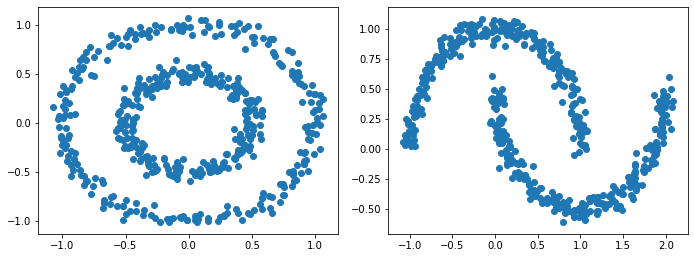

In [18]:
from sklearn import datasets

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.tight_layout(pad=2.0)

circles, _ = datasets.make_circles(n_samples=500, factor=.5, noise=.05, random_state=23)
axs[0].scatter(circles[:,0], circles[:,1])

moons, _ = datasets.make_moons(n_samples=500, noise=.05, random_state=23)
axs[1].scatter(moons[:,0], moons[:,1])

Como vemos, no es posible separar los clústers linealmente. Si ejecutamos k-means sobre dichos datasets para dos clusters (`k=2`) obtenemos el siguiente resultado:

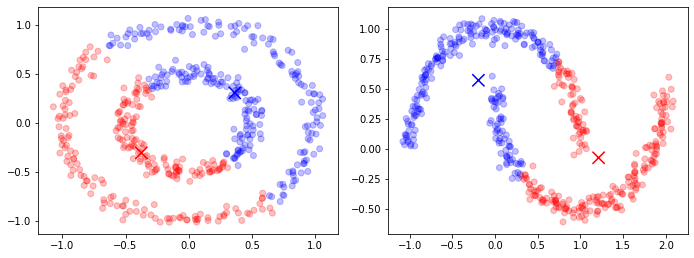

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.tight_layout(pad=2.0)

kmeans = KMeans(n_clusters=2, n_init=1, random_state=23)
kmeans.fit(circles)

labels = kmeans.predict(circles)
centroids = kmeans.cluster_centers_

axs[0].scatter(circles[:,0], circles[:,1], c=plt.cm.brg(labels/2, alpha=.25))
axs[0].scatter(centroids[:,0], centroids[:,1], color=['b','r'], marker="x", s=150)

kmeans = KMeans(n_clusters=2, n_init=1, random_state=23)
kmeans.fit(moons)

labels = kmeans.predict(moons)
centroids = kmeans.cluster_centers_

axs[1].scatter(moons[:,0], moons[:,1], c=plt.cm.brg(labels/2, alpha=.25))
axs[1].scatter(centroids[:,0], centroids[:,1], color=['b','r'], marker="x", s=150)

Observamos que los centroides han obviado la forma de los clusters y se han centrado de tal forma que tengan igual número de puntos asociados a cada uno de ellos.

Otro problema de k-means es su **sensibilidad a los datos atípicos** o *outlayers*. Al actualizarse los centroides con la media de todos los puntos que se han asignado a los mismos, los valores atípicos tienen una influencia enorme sobre esta actualización, provocando, generalmente, que los centroides se desplacen más de lo esperado.

Si tenemos el siguiente conjunto de datos:

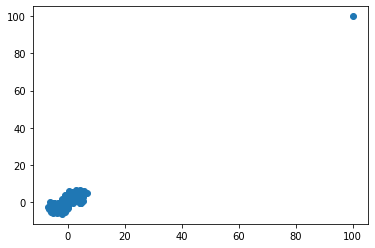

In [20]:
blobs, _ = make_blobs(n_samples=300, n_features=2, centers=[[-3,-3], [3,3]], cluster_std=1.5, random_state=23)
blobs = np.concatenate((blobs, np.array([[100,100]])))

plt.figure()
plt.scatter(blobs[:,0], blobs[:,1])

Y ejecutamos k-means:

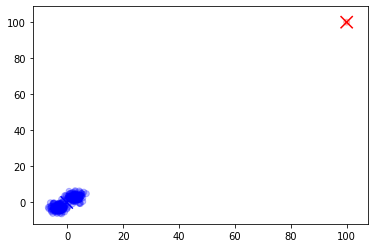

In [21]:
kmeans = KMeans(n_clusters=2, n_init=1, random_state=23)
kmeans.fit(blobs)

labels = kmeans.predict(blobs)
centroids = kmeans.cluster_centers_

plt.figure()
plt.scatter(blobs[:,0], blobs[:,1], c=plt.cm.brg(labels/2, alpha=.25))
plt.scatter(centroids[:,0], centroids[:,1], color=['b','r'], marker="x", s=150)

Como vemos, se han definidos dos clústers: uno para el *outlayer* y otro para el resto de puntos. Esto supone un gran problema y requiere un filtrado previo de los *outlayers*.

Por último, el cálculo de las distancias entre cada punto y los centroides en cada iteración es **extremadamente lento** cuando se tiene un conjunto de datos grande. Para solventarlo, existe una variante llamada **Mini Batch k-Means**, disponible en `sklearn` en la clase [`MiniBatchKMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html).  Esta variante funciona de la siguiente manera: en lugar calcular el nuevo centroide considerando todas las muestras, lo hace con un subconjunto aleatorio de las mismas. De este modo, el tiempo de procesamiento se acelera y, al mismo tiempo, se reduce el *overfitting* y se amortigua el efecto de los *outlayers*. Sin embargo, introduce un nuevo hiperparámetro a optimizar: el número de puntos aleatorios que se seleccionan cada vez que se quiere modificar el centroide.

---

Creado por **Fernando Ortega** (fernando.ortega@upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">